## Introduction
Neural networks, especially their modern "deep" incarnations, are powerful tools for learning from complex data inputs, including images, using layers of connected nodes. For example, a supervised neural network could be trained to recognise pictures of women, using a training data set that included pictures along with labels indicating whether or not there were women in a given image.

Here we demonstrate the use of an autoencoder, a kind of neural network that attempts to reproduce the inputs as outputs. Autoencoders learn to distill efficient low-dimensional representations of data, by trying to predict the data from itself.

We feed our neural network images of written digits, and expect it to approximately reproduce each input image. The image is flattened (ie. stored as a vector) and fed through a succession of dimensionality-reducing layers (the "encoder" network), with the smallest layer having only 2 dimensions, and using a sigmoidal activation function that constrains the values at this layer to be between 0 and 1. The network then expands again through multiple layers (the "decoder"), until it becomes a 784 dimensional vector that is again reshaped back into an image. The model below has 872434 free parameters!

We train this model for a number of epochs (training runs that involve backpropagating through the network and adjusting the weights attached to each node, in order to minimise the loss function), and show how the model changes as we train it further. This is due to the differentiability of the model, which allows computation of the local gradients with respect to the loss function for each of the nodes (a really excellent explanation: https://www.youtube.com/watch?v=59Hbtz7XgjM).

Flux (https://github.com/FluxML/Flux.jl), a Julia Machine Learning Library, is an all-Julia implementation of popular machine learning techniques, implemented in straightforward code, and in keeping with the spirit of Julia as "executable math" (according to its creators). The accompanying "model zoo" provides starting points for building more complex models (as is the case here!).

(This example is inspired by and adapted from: 
https://github.com/FluxML/model-zoo/blob/master/vision/mnist/autoencoder.jl, but the network structure has been changed and visualizations have been included to interrogate the network behavior). 

This example was run on a AMD Ryzen 7 1700 Eight-Core Processor, with an NVIDIA GeForce GTX 1080 Ti.

In [59]:
using PyPlot
using Statistics
using Flux, Flux.Data.MNIST
using Flux: @epochs, onehotbatch, mse, throttle
using Base.Iterators: partition
using Images
using CuArrays

# Import images and labels from data
imgs = MNIST.images()
labels = MNIST.labels();

# Partition into batches of size 1000 and encode images as vectors for modelling step
data = [float(hcat(vec.(imgs)...)) for imgs in partition(imgs, 1000)]
data = gpu.(data)

# Size of the encoding for each layer
N1 = 512 
N2 = 64
N3 = 16

#Define the layers of the neural network, with the inner layer having dimension 2 and a sigmoidal activation function
encoder = Dense(28^2, N1, leakyrelu) |> gpu
encoder2 = Dense(N1, N2, leakyrelu) |> gpu
encoder3 = Dense(N2, N3, leakyrelu) |> gpu
encoder4 = Dense(N3, 2, sigmoid) |> gpu
decoder4 = Dense(2, N3, leakyrelu) |> gpu
decoder3 = Dense(N3, N2, leakyrelu) |> gpu
decoder2 = Dense(N2, N1, leakyrelu) |> gpu
decoder = Dense(N1, 28^2, leakyrelu) |> gpu

#Define the model and loss function
m = Chain(encoder, encoder2, encoder3, encoder4, decoder4, decoder3, decoder2, decoder)
loss(x) = mse(m(x), x)

evalcb = throttle(() -> @show(loss(data[1])), 5)
opt = ADAM(params(m));

## Functions

Functions to:  
* img(): convert a vector of values generated by our network back into an image  
* sample(): sample 20 random images from the data and compare them to the corresponding images generated by the network when the sample images are used as inputs. This shows us how well the model "reproduces" the images in question.  
* plot_encoder(): map 1000 images from our dataset onto the innermost, 2 dimensional layer of network, by running them through the "encoder" layers of the network, and colouring them by the labelled value of the image from 0-9 (the "ground truth). This shows us how the network is projects different images onto the 2D layer, and gives some insight into how different digits are represented distinctly.  
* plot_decoder(): feed uniform values (sampled with a specified granularity) from the 2 dimensional grid through the "decoding" portion of the network, in order to see how 2D points on the innermost layer are "decoded" into images. This again shows us how distinct regions on the grid map onto distinct representations of digits, and gives insight into regions of overlap or ambiguity in the output digit. 

In [60]:
#Convert a vector to an image representation
img(x::Vector) = Gray.(reshape(clamp.(x, 0, 1), 28, 28))

#Sample 20 random digit representations from the data, and show the model's representations of these data below them
function sample()
  # 20 random digits
  before = [imgs[i] for i in rand(1:length(imgs), 20)]
  # Before and after images
  after = img.(map(x -> cpu(m)(float(vec(x))).data, before))
  # Stack them all together
  hcat(vcat.(before, after)...)
end

#Show where the innermost layer maps a given digit to on a 2D plot, coloured by each digit
function plot_encoder()
    first1000 = Tracker.data(cpu(m[1:4](data[1][:,1:1000])));
    for i in 0:9
        selectedpoints=first1000[:,labels[1:1000].==i]
        plot(selectedpoints[1,:],selectedpoints[2,:],".",label="$(i)")
        legend()
    end
end

#Show what points on the innermost 2D plane map to in terms of image representations 
#"Granularity" controls how finely these points are sampled
function plot_decoder(granularity::Int)    
    hcat([vcat(img.([Tracker.data(cpu(m)[5:8]([i,1-j])) for j in 0:1/granularity:1])...) for i in 0:1/granularity:1]...)
end;

## Results: a single epoch
After a single training epoch, we see that the output images are clearly poor reflections of the input images. The encoder plot (mapping images onto a 2D projection) manages to distinguish the 1s most clearly, but maps all other digits to one corner of the space. Finally, samples from the unit square map onto vaguely 8 shaped blobs, reiterating a lack of separation due to insufficient training.

In [61]:
@epochs 1 Flux.train!(loss, zip(data), opt, cb = evalcb)

┌ Info: Epoch 1
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93


loss(data[1]) = 0.107868254f0 (tracked)


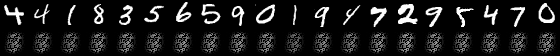

In [62]:
sample()

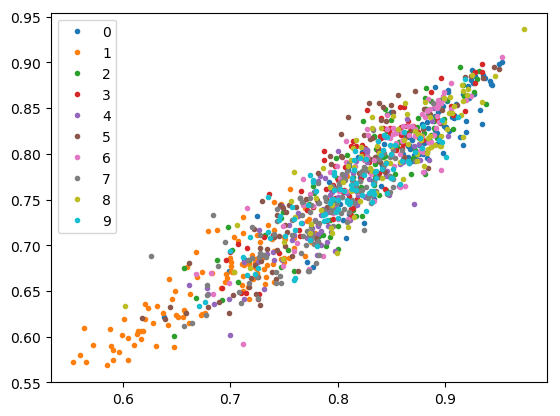

In [64]:
plot_encoder()

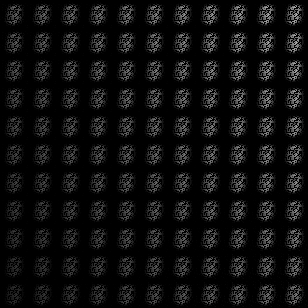

In [65]:
plot_decoder(10)

## Results: 10 epochs

After 10 epochs, more of an attempt is made to distinguish digits, although the success of this attempt is very limited. The 1s are starting to separate more clearly on the 2D space, and more structure is emerging for the other digits. In the mapping from 2D onto images, however, the digits still look quite amorphous, although those in the bottom left look more "1-like".

In [66]:
@epochs 10 Flux.train!(loss, zip(data), opt, cb = evalcb)

loss(data[1]) = 0.08348987f0 (tracked)


┌ Info: Epoch 1
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 2
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 3
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 4
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 5
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 6
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 7
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 8
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 9
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 10
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93


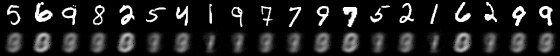

In [67]:
sample()

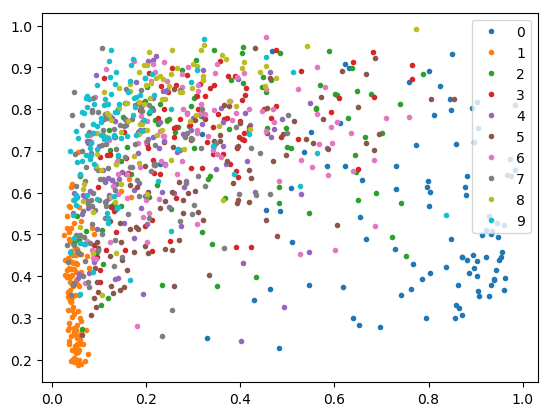

In [68]:
plot_encoder()

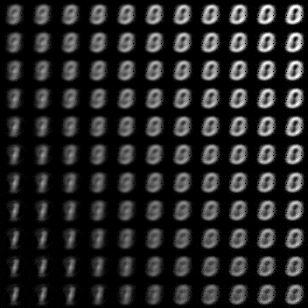

In [69]:
plot_decoder(10)

## Results: 100 epochs

After 100 epochs, the resulting images are much more similar to the initial digits. We also  see more structured regions in the 2D projection, although 4s and 9s, for example, are still relatively interspersed. The projection from the unit square onto images similarly shows regions of distinct digits, as well as regions with more ambiguous "hybrid" digist. This gives us an impression of what features the network can clearly distinguish, and which elements of the digit images are more difficult for it to tell apart (for example, the top loop on a 9 can apparently look quite a lot like some handwritten 4s. 


In [70]:
@epochs 100 Flux.train!(loss, zip(data), opt, cb = evalcb)

loss(data[1]) = 0.06020613f0 (tracked)


┌ Info: Epoch 1
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 2
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 3
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 4
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 5
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 6
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 7
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 8
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 9
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 10
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 11
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 12
└ @ Main /home/ben/.juli

loss(data[1]) = 0.04704607f0 (tracked)


┌ Info: Epoch 35
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 36
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 37
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 38
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 39
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 40
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 41
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 42
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 43
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 44
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 45
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 46
└ @ Main /home/

loss(data[1]) = 0.04179124f0 (tracked)


┌ Info: Epoch 71
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 72
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 73
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 74
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 75
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 76
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 77
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 78
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 79
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 80
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 81
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 82
└ @ Main /home/

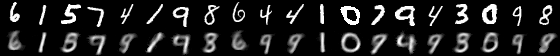

In [71]:
sample()

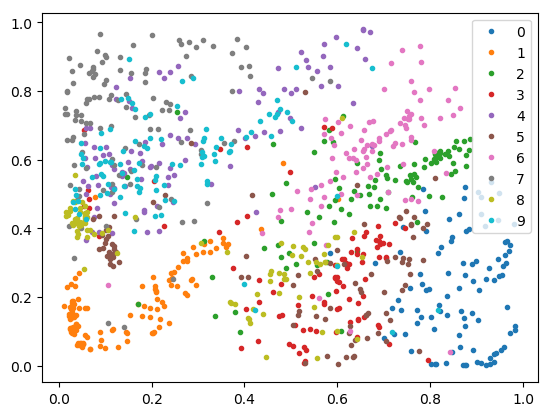

In [72]:
plot_encoder()

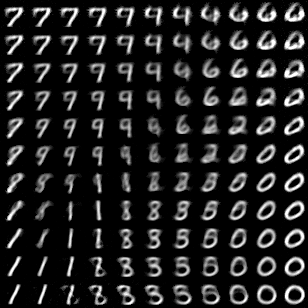

In [73]:
plot_decoder(10)

## Results: 500 epochs

The resulting images are even crisper at this point, and the separation in the 2D plane is cleaner. Additionally, a much larger proportion of the resulting image space is populated by easily recognisable digits.

In [74]:
@epochs 500 Flux.train!(loss, zip(data), opt, cb = evalcb)

loss(data[1]) = 0.039797407f0 (tracked)


┌ Info: Epoch 1
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 2
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 3
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 4
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 5
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 6
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 7
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 8
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 9
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 10
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 11
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 12
└ @ Main /home/ben/.juli

loss(data[1]) = 0.038282435f0 (tracked)


┌ Info: Epoch 34
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 35
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 36
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 37
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 38
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 39
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 40
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 41
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 42
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 43
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 44
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 45
└ @ Main /home/

loss(data[1]) = 0.037181024f0 (tracked)


┌ Info: Epoch 70
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 71
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 72
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 73
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 74
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 75
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 76
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 77
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 78
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 79
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 80
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 81
└ @ Main /home/

loss(data[1]) = 0.035706174f0 (tracked)


┌ Info: Epoch 106
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 107
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 108
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 109
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 110
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 111
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 112
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 113
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 114
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 115
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 116
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 117
└ @

loss(data[1]) = 0.0354318f0 (tracked)


┌ Info: Epoch 143
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 144
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 145
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 146
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 147
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 148
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 149
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 150
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 151
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 152
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 153
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 154
└ @

loss(data[1]) = 0.034776896f0 (tracked)


┌ Info: Epoch 178
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 179
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 180
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 181
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 182
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 183
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 184
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 185
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 186
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 187
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 188
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 189
└ @

loss(data[1]) = 0.034379832f0 (tracked)


┌ Info: Epoch 214
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 215
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 216
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 217
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 218
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 219
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 220
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 221
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 222
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 223
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 224
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 225
└ @

loss(data[1]) = 0.034118116f0 (tracked)


┌ Info: Epoch 249
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 250
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 251
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 252
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 253
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 254
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 255
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 256
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 257
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 258
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 259
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 260
└ @

loss(data[1]) = 0.033413835f0 (tracked)


┌ Info: Epoch 285
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 286
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 287
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 288
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 289
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 290
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 291
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 292
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 293
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 294
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 295
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 296
└ @

loss(data[1]) = 0.03384386f0 (tracked)


┌ Info: Epoch 321
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 322
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 323
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 324
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 325
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 326
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 327
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 328
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 329
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 330
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 331
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 332
└ @

loss(data[1]) = 0.032985676f0 (tracked)


┌ Info: Epoch 356
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 357
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 358
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 359
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 360
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 361
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 362
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 363
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 364
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 365
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 366
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 367
└ @

loss(data[1]) = 0.03301513f0 (tracked)


┌ Info: Epoch 392
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 393
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 394
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 395
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 396
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 397
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 398
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 399
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 400
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 401
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 402
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 403
└ @

loss(data[1]) = 0.032920476f0 (tracked)


┌ Info: Epoch 427
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 428
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 429
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 430
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 431
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 432
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 433
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 434
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 435
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 436
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 437
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 438
└ @

loss(data[1]) = 0.033085946f0 (tracked)


┌ Info: Epoch 462
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 463
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 464
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 465
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 466
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 467
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 468
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 469
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 470
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 471
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 472
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 473
└ @

loss(data[1]) = 0.03242768f0 (tracked)


┌ Info: Epoch 497
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 498
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 499
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93
┌ Info: Epoch 500
└ @ Main /home/ben/.julia/packages/Flux/jsf3Y/src/optimise/train.jl:93


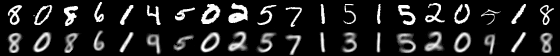

In [75]:
sample()

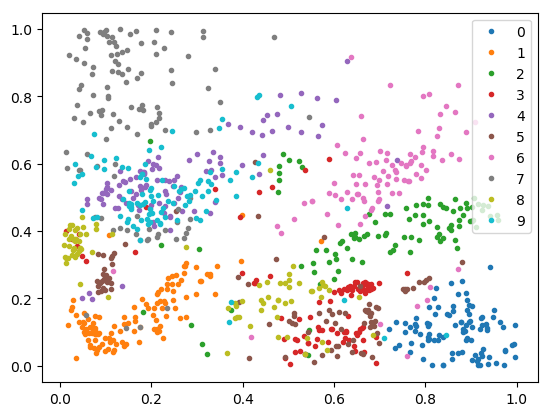

In [76]:
plot_encoder()

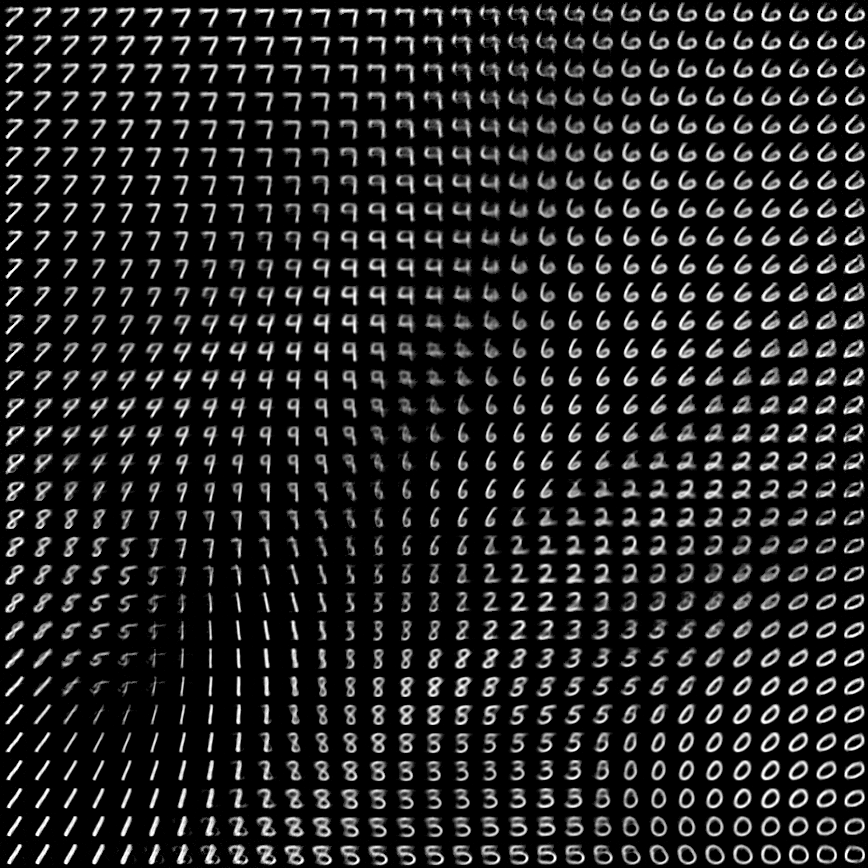

In [78]:
plot_decoder(30)